The goal is to shift the LSST datavectors in the $\Omega_m-A_s$ plane

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import getdist
from multiprocessing import Pool
from getdist import plots, MCSamples, WeightedSamples
%matplotlib inline

import sys
import os

sys.path.append(os.path.join(os.path.dirname("__file__"), '../LSST_emulation/'))
# LSST
from cocoa_emu import *
from cocoa_emu.emulator import NNEmulator, GPEmulator
from cocoa_emu.data_model import LSST_3x2

import emcee
import time

In [471]:
### LSST MCMC Functions

def plot_cosmo_contours(sample_list, legend_labels):
    names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
    labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True, markers=truth_dict)
    
def add_bias(bias_theta, datavector):
    for i in range(5):
        factor = (bias_theta[i] / bias_fid[i])**bias_mask[i]
        datavector = factor * datavector
    return datavector

def add_shear_calib(m, datavector):
    for i in range(5):
        factor = (1 + m[i])**shear_calib_mask[i]
        datavector = factor * datavector
    return datavector

def hard_prior(theta, params_prior):
    """
    A function to impose a flat prior on a set of parameters.
    :theta: The set of parameter values
    :params_prior: The minimum and the maximum value of the parameters on which this prior is imposed
    """
    is_lower_than_min = bool(np.sum(theta < params_prior[:,0]))
    is_higher_than_max = bool(np.sum(theta > params_prior[:,1]))
    if is_lower_than_min or is_higher_than_max:
        return -np.inf
    else:
        return 0.
    
cosmo_prior_lim = np.array([[1.61, 3.91],# planck [1.61,  3.91,  'uniform'],
                       [0.87, 1.07], # planck [0.9,   1.1,   'uniform']
                       [55, 91],
                       [0.01, 0.04], # [0.001, 0.04, 'uniform'],
                       [0.001, 0.99]]) # [0.005, 0.99,  'uniform'],

# parameters of the analysis, and their priors

ia_prior_lim = np.array([[-5., 5.],
                       [-5., 5.]])

bias_prior_lim = np.array([[0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.],
                       [0.8, 3.]])

baryon_prior_lim = np.array([[-3., 12.],
                             [-2.5, 2.5]])

baryon_prior_lim = 3. * baryon_prior_lim 

dz_source_std   = 0.002 * np.ones(5)
dz_lens_std     = 0.005 * np.ones(5)
shear_calib_std = 0.005 * np.ones(5)
    
def lnprior(theta):
    cosmo_theta = theta[:5]
    ns          = cosmo_theta[1]

    ns_prior    = 0.
    
    dz_source   = theta[5:10]
    ia_theta    = theta[10:12]
    dz_lens     = theta[12:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    
    cosmo_prior = hard_prior(cosmo_theta, cosmo_prior_lim) + ns_prior
    ia_prior    = hard_prior(ia_theta, ia_prior_lim)
    bias_prior  = hard_prior(bias, bias_prior_lim)
    baryon_prior = hard_prior(baryon_q, baryon_prior_lim)
    
    dz_source_lnprior   = -0.5 * np.sum((dz_source / dz_source_std)**2)
    dz_lens_lnprior     = -0.5 * np.sum((dz_lens / dz_lens_std)**2)
    shear_calib_lnprior = -0.5 * np.sum((shear_calib / shear_calib_std)**2)
    
    return cosmo_prior + ia_prior + dz_source_lnprior + dz_lens_lnprior + \
            shear_calib_lnprior + bias_prior + baryon_prior
    
def ln_lkl(theta):
    model_datavector = get_data_vector_emu(theta)[0]
    delta_dv = (model_datavector - data_model.dv_obs)[data_model.mask_3x2]
    return -0.5 * delta_dv @ data_model.masked_inv_cov @ delta_dv

def lnprob(theta):
    return lnprior(theta) + ln_lkl(theta)

def get_data_vector_emu(theta):
    """
    Function to get the emulated data vector (including the effect of galaxy bias, baryons, etc.)
    """
    cosmo_ia_dz_theta = theta[:17]
    bias        = theta[17:22]
    shear_calib = theta[22:27]
    baryon_q    = theta[27:29]
    datavector = data_model.compute_datavector(cosmo_ia_dz_theta)
    datavector = np.array(datavector)
    datavector = add_bias(bias, datavector)
    datavector = add_shear_calib(shear_calib, datavector)
    return datavector

In [472]:
# open the emulator
# Get the LSST covariance and fid data
path = '/home/grads/data/evan/LSST_emulation/data/lsst_y1/'
lsst_cov = np.loadtxt(path+'cov_lsst_y1')
fid_cos = np.loadtxt(path+'lsst_y1_data_fid',dtype=np.float32)[:,1]

lsst_y1_cov = np.zeros((1560, 1560))
for line in lsst_cov:
    i = int(line[0])
    j = int(line[1])

    cov_g_block  = line[-2]
    cov_ng_block = line[-1]

    cov_ij = cov_g_block + cov_ng_block

    lsst_y1_cov[i,j] = cov_ij
    lsst_y1_cov[j,i] = cov_ij
    
fid = torch.Tensor(fid_cos)
cov = torch.Tensor(lsst_y1_cov)

configfile = path+'../../configs/nn_emu.yaml'
config = Config(configfile)

config_args     = config.config_args
config_args_io  = config_args['io']
config_args_data = config_args['data']

savedir = path+'../../output/nn_emu/'

N_DIM         = 17
data_model    = LSST_3x2(N_DIM, config_args_io, config_args_data)
data_model.emu_type = 'nn'
OUTPUT_DIM = 1560

emu = NNEmulator(N_DIM, OUTPUT_DIM, data_model.dv_fid, data_model.dv_std)    
emu.load(path+'../../model/nn_emu/model')
# ======================================================

data_model.emu = emu

bias_fid         = data_model.bias_fid
bias_mask        = data_model.bias_mask
shear_calib_mask = data_model.shear_calib_mask

N_MCMC        = 5000
N_WALKERS     = 120
NDIM_SAMPLING = 32

theta0    = np.array([3.0675, 0.97, 69.0, 0.0228528, 0.1199772, 
                      0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])

theta_std = np.array([0.01, 0.001, 0.1, 0.001, 0.002, 
                      0.002, 0.002, 0.002, 0.002, 0.002, 
                      0.1, 0.1,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.03, 0.03, 0.03, 0.03, 0.03,
                      0.005, 0.005, 0.005, 0.005, 0.005, 
                      0.1, 0.1,0.01,0.01,0.01]) 

# Starting position of the emcee chain
pos0 = theta0[np.newaxis] + 3. * theta_std[np.newaxis] * np.random.normal(size=(N_WALKERS, NDIM_SAMPLING))

In [4]:
with Pool(10) as pool:
    emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
    emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)

100%|█████████████████████████████████████████████████| 5000/5000 [05:38<00:00, 14.76it/s]


In [5]:
N_BURN_IN = 1500
N_THIN    = 10

In [6]:
samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))

Removed no burn in


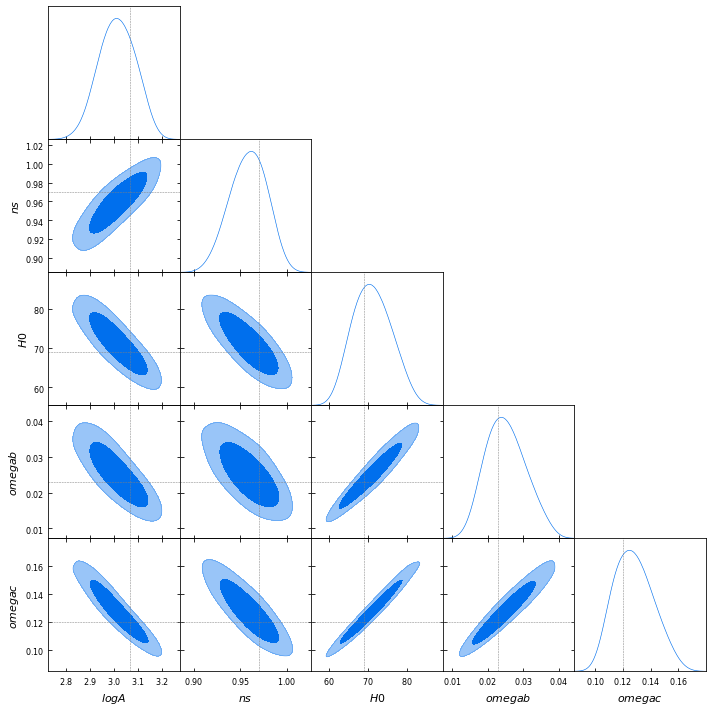

In [7]:
plot_cosmo_contours([samples], ['Fiducial scalecut'])

In [23]:
names = ['logA', 'ns', 'H0', 'omegab', 'omegac']
labels =  ['logA', 'ns', 'H0', 'omega b', 'omega c']

chain = MCSamples(samples=samples[...,:5],names=names,labels=labels)

stdev_oc = np.sqrt(chain.cov(['omegac'])[0][0])
stdev_as = np.sqrt(chain.cov(['logA'])[0][0])
print(stdev_oc)
print(stdev_as)


Removed no burn in
0.014380539259390182
0.07701705313942786


Now we can just shift each parameter as needed:
- shift $A_s$ down up to 2 sigma
- shift $\Omega_c$ up up to 2 sigma

In [26]:
#start with As$
cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
data_vectors = []

for i in range(4):
    params = [list(np.array(cosmo_truth) - 0.5*i*np.array([stdev_as,0.,0.,0.,0.0]))]
    params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    params = [item for sublist in params for item in sublist]
    dv = get_data_vector_emu(np.array(params))
    data_vectors.append(dv)
    
#now omegam
for i in range(4):
    params = [list(np.array(cosmo_truth) - 0.5*i*np.array([0.,0.,0.,0.,stdev_oc]))]
    params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    params = [item for sublist in params for item in sublist]
    dv = get_data_vector_emu(np.array(params))
    data_vectors.append(dv)
    
print(len(data_vectors))

8


In [27]:
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|█████████████████████████████████████████████████| 5000/5000 [06:15<00:00, 13.33it/s]


[array([[3.03255851e+00, 9.67395150e-01, 7.22442264e+01, 2.77102218e-02,
        1.27872283e-01],
       [3.03503310e+00, 9.67055513e-01, 7.20978533e+01, 2.76650939e-02,
        1.27508167e-01],
       [3.03223392e+00, 9.66107487e-01, 7.22723784e+01, 2.78409940e-02,
        1.27964401e-01],
       ...,
       [3.11283483e+00, 9.50204214e-01, 6.69505320e+01, 1.87860500e-02,
        1.14299970e-01],
       [3.13845027e+00, 9.66257823e-01, 6.56085770e+01, 1.81587025e-02,
        1.10227950e-01],
       [3.15490264e+00, 9.72871168e-01, 6.44012310e+01, 1.68380012e-02,
        1.06553815e-01]]), array([[3.10867483e+00, 9.78749058e-01, 6.60097860e+01, 1.94357969e-02,
        1.09702831e-01],
       [3.10732490e+00, 9.80484171e-01, 6.56784790e+01, 1.93593953e-02,
        1.09242012e-01],
       [3.10712960e+00, 9.80656023e-01, 6.56698317e+01, 1.93110710e-02,
        1.09210354e-01],
       ...,
       [3.10591647e+00, 9.77197583e-01, 6.74334423e+01, 2.45379618e-02,
        1.14679359e-01],
   

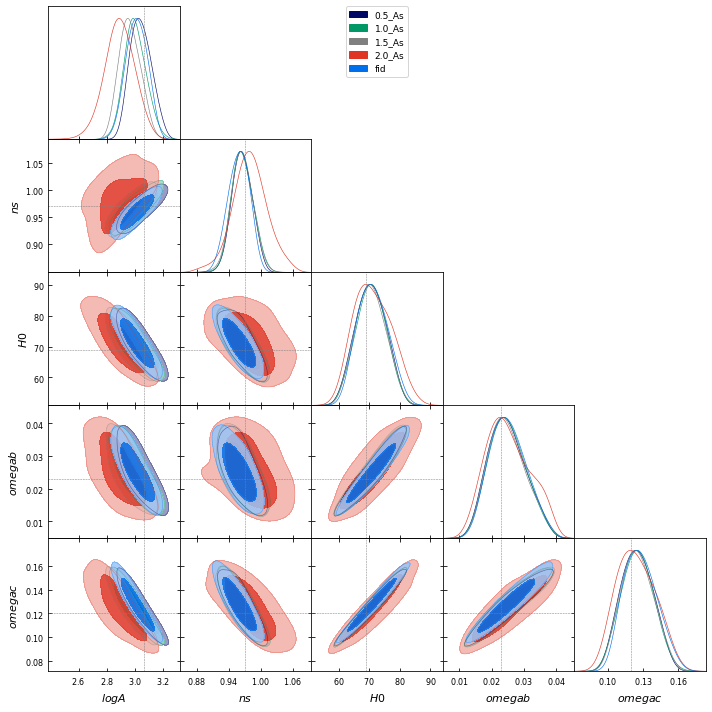

In [28]:
print(shifted_samples)
plot_cosmo_contours([shifted_samples[0],shifted_samples[1],shifted_samples[2],shifted_samples[3],samples],['0.5_As','1.0_As','1.5_As','2.0_As','fid'])


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


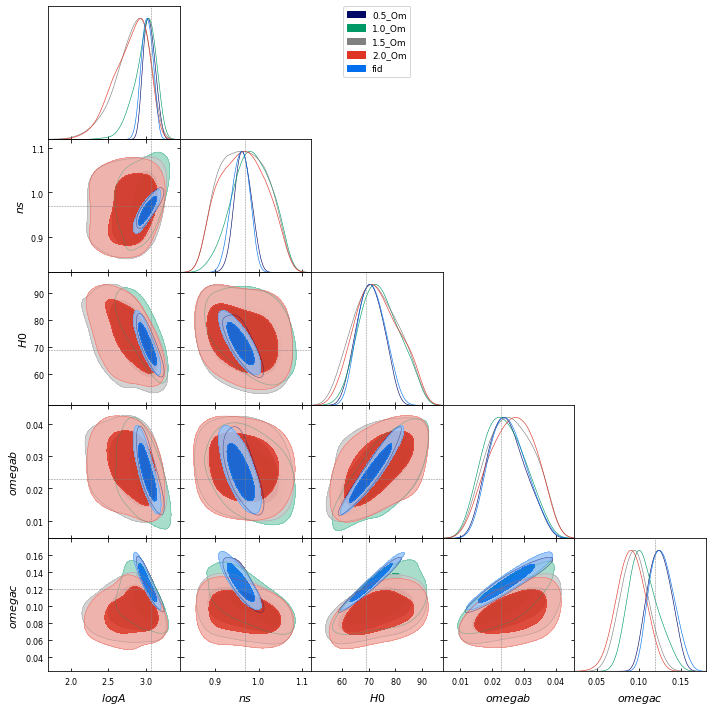

In [30]:
#print(shifted_samples)
samples_list = shifted_samples.append(samples)
plot_cosmo_contours([shifted_samples[4],shifted_samples[5],shifted_samples[6],shifted_samples[7],samples],['0.5_Om','1.0_Om','1.5_Om','2.0_Om','fid'])

Try now to compute the PCs and do shifts along the PC directions.

In [51]:
cov = chain.cov()
evals,evecs = np.linalg.eig(cov)
#print(evecs)
PC_cov = np.linalg.inv(evecs) @ cov @ evecs
print(PC_cov)

[[ 2.51155887e+01 -1.33486971e-15 -1.36782946e-15 -7.77156117e-16
   3.81639165e-16]
 [-7.09655093e-15  1.79654837e-03  2.42293775e-18 -1.11130723e-18
   1.73472348e-18]
 [-6.89661058e-15  3.48579469e-17  1.12815711e-04  6.81226248e-19
   7.74188114e-19]
 [-6.24709552e-16 -4.01678905e-19  9.89634253e-18  4.04304067e-06
   6.58991633e-19]
 [ 2.33255071e-17  4.28871641e-18 -8.10818897e-18 -3.01014334e-19
   3.74947480e-07]]


In [50]:
mean = chain.mean(['logA','ns','H0','omegab','omegac'])
#change basis to eigenbasis/PC basis
mean_eb = np.linalg.inv(evecs) @ mean
print(mean_eb)

[ 7.10826727e+01 -4.06503867e+00  5.52502890e-01 -4.86314163e-02
  2.17381761e-01]


In [58]:
# shift along first PC
data_vectors = []
for i in range(4):
    params = [list(mean_eb - 0.5*i*np.array([PC_cov[0][0],0.,0.,0.,0.0]))]
    #change basis back to cosmo params
    params = [list(evecs @ params[0])]
    params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    params = [item for sublist in params for item in sublist]
    dv = get_data_vector_emu(np.array(params))
    data_vectors.append(dv)

100%|█████████████████████████████████████████████████| 5000/5000 [06:02<00:00, 13.79it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


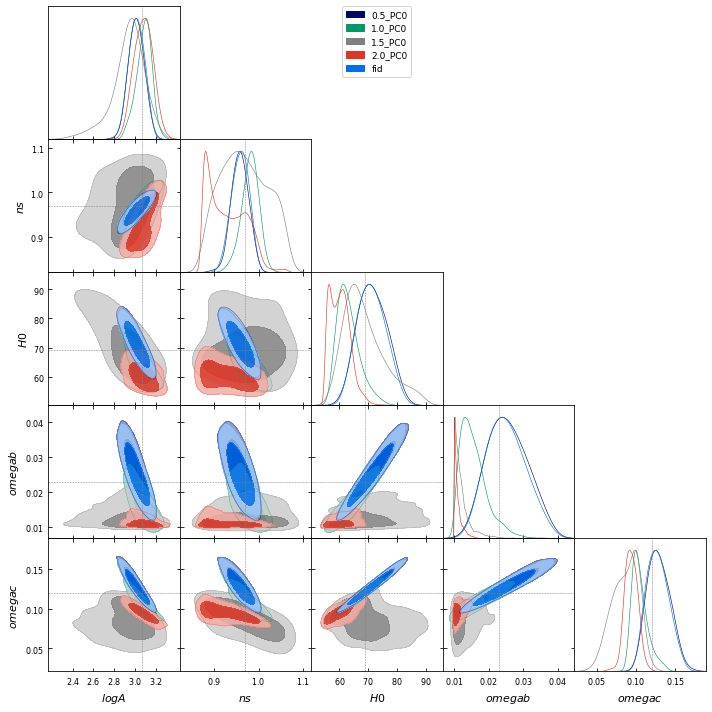

In [59]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)
    
plot_cosmo_contours([shifted_samples[0],shifted_samples[1],shifted_samples[2],shifted_samples[3],samples],['0.5_PC0','1.0_PC0','1.5_PC0','2.0_PC0','fid'])


In [74]:
transformed_samples = []
for s in shifted_samples:
    t_s = []
    for _s in s:
        _t_s = np.linalg.inv(evecs) @ _s
        t_s.append(_t_s)
    t_s = np.array(t_s)
    transformed_samples.append(t_s)

t_s = []    
for _s in samples[:,:5]:
    _t_s = np.linalg.inv(evecs) @ _s
    t_s.append(_t_s)
t_s = np.array(t_s)
transformed_samples.append(t_s)


In [222]:
def plot_cosmo_contours_PC(sample_list, legend_labels):
    names = [pc0,pc1,pc2,pc3,pc4]
    labels =  names
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


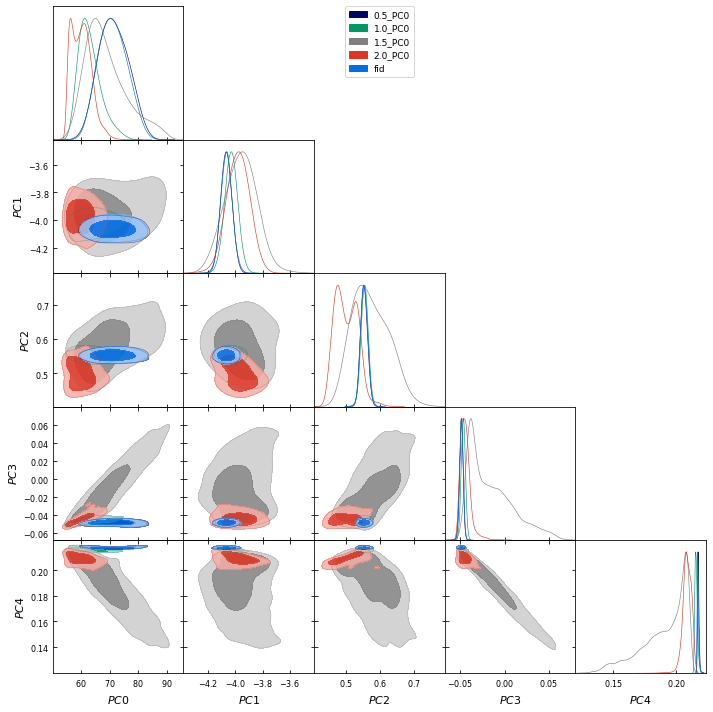

In [77]:
plot_cosmo_contours_PC(transformed_samples,['0.5_PC0','1.0_PC0','1.5_PC0','2.0_PC0','fid'])

In [111]:
# shift along last PC
data_vectors = []
vals = []

cosmo_truth = np.array([3.0675, 0.97, 69., 0.0228528, 0.1199772])
truth_eb = np.linalg.inv(evecs) @ cosmo_truth
print(truth_eb)

for i in range(1,5):
    params = [list(truth_eb - 0.5*i*np.array([0.,0.,0.,0.,np.sqrt(PC_cov[4][4])]))]
    vals.append(truth_eb[4]- 0.5*i*np.sqrt(PC_cov[4][4]))
    #change basis back to cosmo params
    params = [list(evecs @ params[0])]
    params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    params = [item for sublist in params for item in sublist]
    dv = get_data_vector_emu(np.array(params))
    data_vectors.append(dv)

[ 6.89512724e+01 -4.09046819e+00  5.53095410e-01 -4.86253330e-02
  2.17251497e-01]


In [112]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)


100%|█████████████████████████████████████████████████| 5000/5000 [05:50<00:00, 14.27it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


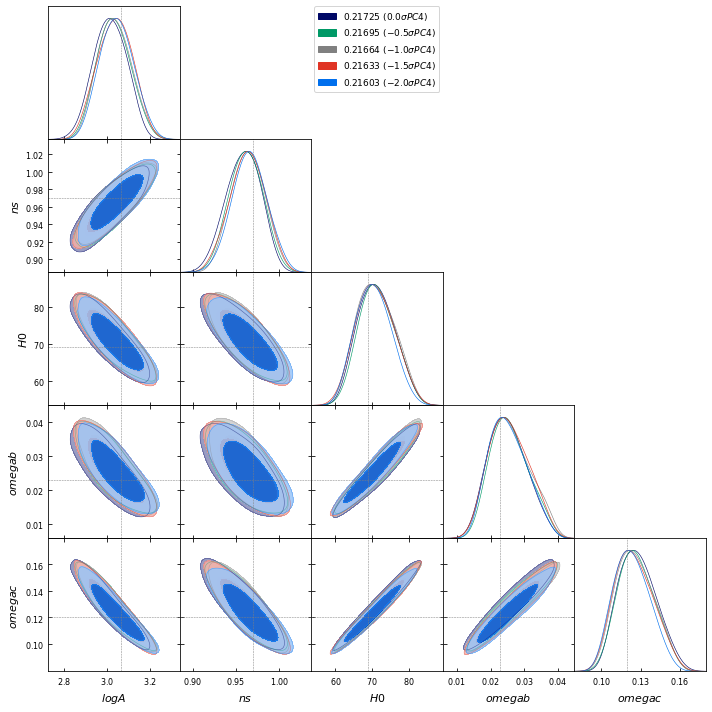

In [113]:
    aplot_cosmo_contours([samples, shifted_samples[0],shifted_samples[1],shifted_samples[2],shifted_samples[3]],
                    ['{:.5f} $(0.0\sigma PC4)$'.format(truth_eb[4]),
                     '{:.5f} $(-0.5\sigma PC4)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma PC4)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma PC4)$'.format(vals[2]),
                     '{:.5f} $(-2.0\sigma PC4)$'.format(vals[3])])
                     

In [114]:
transformed_samples = []

t_s = []    
for _s in samples[:,:5]:
    _t_s = np.linalg.inv(evecs) @ _s
    t_s.append(_t_s)
t_s = np.array(t_s)
transformed_samples.append(t_s)

for s in shifted_samples:
    t_s = []
    for _s in s:
        _t_s = np.linalg.inv(evecs) @ _s
        t_s.append(_t_s)
    t_s = np.array(t_s)
    transformed_samples.append(t_s)


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


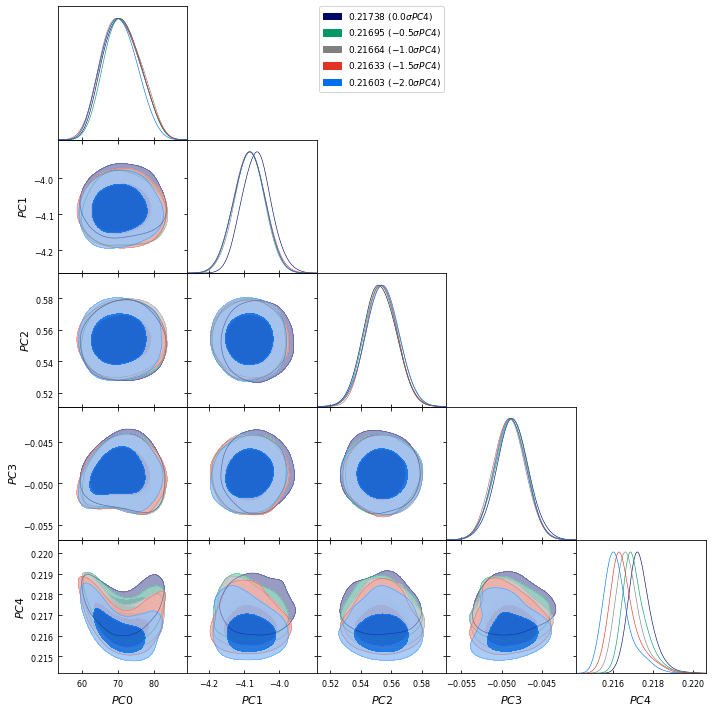

In [115]:
plot_cosmo_contours_PC(transformed_samples,
                    ['{:.5f} $(0.0\sigma PC4)$'.format(truth_eb[4]),
                     '{:.5f} $(-0.5\sigma PC4)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma PC4)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma PC4)$'.format(vals[2]),
                     '{:.5f} $(-2.0\sigma PC4)$'.format(vals[3])])

## Reparameterization
Convert to $(\sigma_8,n_s,H_0,\Omega_b,\Omega_m)$

In [354]:
# reparameterize
def emu_to_params(theta,means=None):
    logAs = theta[:,0]
    ns    = theta[:,1]
    H0    = theta[:,2]
    ombh2 = theta[:,3]
    omch2 = theta[:,4]
    
    omnh2 = (3.046/3)**(3/4)*0.06/94.1
    
    h = H0/100
    As = np.exp(logAs)/(10**10)
    
    omb = ombh2/(h**2)
    omc = omch2/(h**2)
    omn = omnh2/(h**2)
    
    omm = omb+omc+omn
    ommh2 = omm*(h**2)
    
    sigma_8 = (As/3.135e-9)**(1/2) * \
              (ombh2/0.024)**(-0.272) * \
              (ommh2/0.14)**(0.513) * \
              (3.123*h)**((ns-1)/2) * \
              (h/0.72)**(0.698) * \
              (omm/0.27)**(0.236) * \
              (1-0.014)
        
    return np.transpose(np.array([sigma_8,ns,H0,omb,omm]))
                

def params_to_emu(theta):
    sigma8 = theta[:,0]
    ns = theta[:,1]
    H0 = theta[:,2]
    ob = theta[:,3]
    om = theta[:,4]
    
    h = H0/100
    omnh2 = (3.046/3)**(3/4)*0.06/94.1
    on = omnh2/(h**2)
    
    oc = om-ob-on
    obh2 = ob*(h**2)
    och2 = oc*(h**2)
    omh2 = om*(h**2)
    
    step =  (sigma8/(1-0.014)) * \
            (obh2/0.024)**(0.272) * \
            (omh2/0.14)**(-0.513) * \
            (3.123*h)**(-(ns-1)/2) * \
            (h/0.72)**(-0.698) * \
            (om/0.27)**(-0.236)
    As = (step**2)*3.135e-9
    logAs = np.log(As*(10**10))
    
    return np.transpose(np.array([logAs,ns,H0,obh2,och2]))

[[3.067500e+00 9.700000e-01 6.900000e+01 2.285280e-02 1.199772e-01]]
[[8.25018076e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
  3.01354628e-01]]
[[3.067500e+00 9.700000e-01 6.900000e+01 2.285280e-02 1.199772e-01]]
Removed no burn in


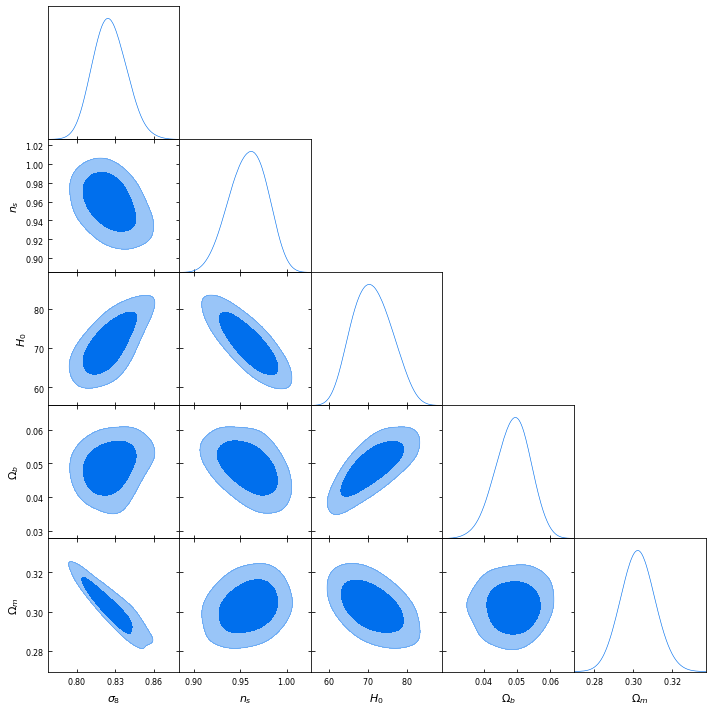

In [356]:
#test
truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
truth_converted = emu_to_params(np.array([truth]))
print(np.array([truth]))
print(truth_converted)
print(params_to_emu(truth_converted))

converted_samples = emu_to_params(samples)
names = ['sigma8','ns','H0','Omegab','omegam']
labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
re_chain = MCSamples(samples=converted_samples,names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(re_chain, filled=True)

In [402]:
# Create log chains
def log_samples(theta,means):
    log_sigma8 = np.log(theta[:,0])#/means[0])
    log_ns     = np.log(theta[:,1])#/means[1])
    log_H0     = np.log(theta[:,2])#/means[2])
    log_omegab = np.log(theta[:,3])#/means[3])
    log_omegam = np.log(theta[:,4])#/means[4])
    
    return np.transpose(np.array([log_sigma8,log_ns,log_H0,log_omegab,log_omegam]))
    
def exp_samples(theta,means):
    sigma8 = np.exp(theta[:,0])#*means[0]
    ns     = np.exp(theta[:,1])#*means[1]
    H0     = np.exp(theta[:,2])#*means[2]
    omegab = np.exp(theta[:,3])#*means[3]
    omegam = np.exp(theta[:,4])#*means[4]
    
    return np.transpose(np.array([sigma8,ns,H0,omegab,omegam]))

In [403]:
m_sigma8 = np.mean(converted_samples[:,0])
m_ns     = np.mean(converted_samples[:,1])
m_H0     = np.mean(converted_samples[:,2])
m_omegab = np.mean(converted_samples[:,3])
m_omegam = np.mean(converted_samples[:,4])

means = np.array([m_sigma8,m_ns,m_H0,m_omegab,m_omegam])
log_s = log_samples(converted_samples,means)

names = ['logsigma8','logns','logH0','logOmegab','logOmegam']
print(log_s)
log_chain = MCSamples(samples=log_s,names=names,labels=names)

cov = log_chain.cov()
evals,evecs = np.linalg.eig(cov)
PC_cov = np.linalg.inv(evecs) @ cov @ evecs
print('variances:')
print(PC_cov)
print('')
print('eigenvalues')
print(evals)
print('')
print('eigenvectors')
print(evecs)

[[-0.21679069 -0.0294597   4.24627382 -2.85187536 -1.13603311]
 [-0.21422352 -0.02953181  4.24722264 -2.86387469 -1.14215366]
 [-0.21425672 -0.02973322  4.24631919 -2.86560563 -1.14204567]
 ...
 [-0.21994898 -0.02722364  4.23053791 -2.81797376 -1.12775902]
 [-0.21857234 -0.02706963  4.22776942 -2.8353246  -1.13295811]
 [-0.21978687 -0.02926323  4.22416468 -2.86335939 -1.13485995]]
Removed no burn in
variances:
[[ 1.56942545e-02  2.60208521e-18  1.35525272e-19 -5.42101086e-19
  -2.18195687e-18]
 [-2.80876125e-18  2.69500995e-03  1.08420217e-18 -9.75781955e-19
  -1.62630326e-19]
 [-4.34527902e-19 -3.52365706e-19  4.62487096e-04 -5.42101086e-20
   2.30392962e-19]
 [-1.48294293e-18  2.28698896e-19  9.48676901e-20  2.57739680e-05
  -1.86770765e-19]
 [ 1.87167812e-18 -1.94732875e-18 -7.11507676e-20  3.48977574e-19
   5.18652445e-05]]

eigenvalues
[1.56942545e-02 2.69500995e-03 4.62487096e-04 2.57739680e-05
 5.18652445e-05]

eigenvectors
[[-0.04316284 -0.24217858 -0.31908564 -0.87416867 -0.27

In [404]:
# shift along 2nd to last PC (most constraining)
pc = 3
data_vectors = []
vals = []

subtract_arr = np.zeros(5)
subtract_arr[pc] = np.sqrt(PC_cov[pc][pc])
print(subtract_arr)

truth_eb = np.linalg.inv(evecs) @ np.log(truth_converted[0])

for i in range(1,5):
    params = [list(truth_eb - 0.5*i*subtract_arr)]
    vals.append(truth_eb[pc]- 0.5*i*np.sqrt(PC_cov[pc][pc]))
    params = np.array([evecs @ params[0]])
    exp_params = exp_samples(params,means)
    cosmo_params = list(params_to_emu(exp_params))
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])
    cosmo_params = [item for sublist in cosmo_params for item in sublist]
    dv = get_data_vector_emu(np.array(cosmo_params))
    data_vectors.append(dv)

[0.         0.         0.         0.00507681 0.        ]


In [388]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|█████████████████████████████████████████████████| 5000/5000 [05:46<00:00, 14.44it/s]


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


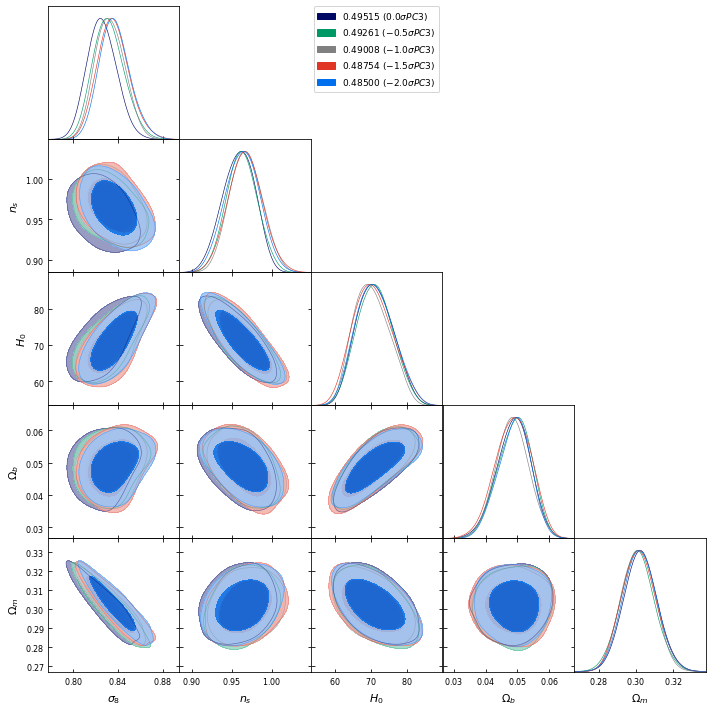

In [411]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)
    g.export('s8-shift.pdf') 

plot_cosmo_contours([emu_to_params(samples), 
                     emu_to_params(shifted_samples[0]),
                     emu_to_params(shifted_samples[1]),
                     emu_to_params(shifted_samples[2]),
                     emu_to_params(shifted_samples[3])],
                    ['{:.5f} $(0.0\sigma PC3)$'.format(truth_eb[pc]),
                     '{:.5f} $(-0.5\sigma PC3)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma PC3)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma PC3)$'.format(vals[2]),
                     '{:.5f} $(-2.0\sigma PC3)$'.format(vals[3])])
                     

In [420]:
transformed_samples = []

t_s = []
for _s in emu_to_params(samples):
    _t_s = np.linalg.inv(evecs) @ (log_samples(np.array([_s]),0))[0]
    t_s.append(_t_s)
t_s = np.array(t_s)
transformed_samples.append(t_s)

for s in shifted_samples:
    t_s = []
    for _s in emu_to_params(s):
        _t_s = np.linalg.inv(evecs) @ (log_samples(np.array([_s]),0))[0]
        t_s.append(_t_s)
    t_s = np.array(t_s)
    transformed_samples.append(t_s)

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


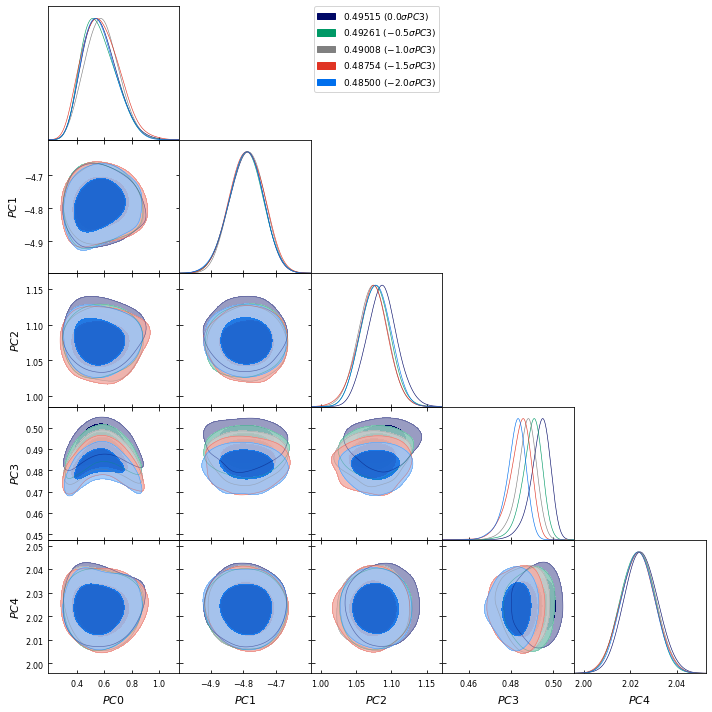

In [421]:
plot_cosmo_contours_PC(transformed_samples,
                    ['{:.5f} $(0.0\sigma PC3)$'.format(truth_eb[pc]),
                     '{:.5f} $(-0.5\sigma PC3)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma PC3)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma PC3)$'.format(vals[2]),
                     '{:.5f} $(-2.0\sigma PC3)$'.format(vals[3])])

In [ ]:
print(evecs)

In [459]:
i=0
pc0 = '$\sigma_8^{:.2f} n_s^{:.2f} H_0^{:.2f}\Omega_b^{:.2f}\Omega_m^{:.2f}$'.format(
    evecs[i][0],
    evecs[i][1],
    evecs[i][2],
    evecs[i][3],
    evecs[i][4])
i+=1
pc1 = '$\sigma_8^{:.2f} n_s^{:.2f} H_0^{:.2f}\Omega_b^{:.2f}\Omega_m^{:.2f}$'.format(
    evecs[i][0],
    evecs[i][1],
    evecs[i][2],
    evecs[i][3],
    evecs[i][4])
i+=1
pc2 = '$\sigma_8^{:.2f} n_s^{:.2f} H_0^{:.2f}\Omega_b^{:.2f}\Omega_m^{:.2f}$'.format(
    evecs[i][0],
    evecs[i][1],
    evecs[i][2],
    evecs[i][3],
    evecs[i][4])
i+=1
pc3 = '$\sigma_8^{:.2f} n_s^{:.2f} H_0^{:.2f}\Omega_b^{:.2f}\Omega_m^{:.2f}$'.format(
    evecs[i][0],
    evecs[i][1],
    evecs[i][2],
    evecs[i][3],
    evecs[i][4])
i+=1
pc4 = '$\sigma_8^{:.2f} n_s^{:.2f} H_0^{:.2f}\Omega_b^{:.2f}\Omega_m^{:.2f}$'.format(
    evecs[i][0],
    evecs[i][1],
    evecs[i][2],
    evecs[i][3],
    evecs[i][4])

In [460]:
print(pc0, PC_cov[0][0])
print(pc1, PC_cov[1][1])
print(pc2, PC_cov[2][2])
print(pc3, PC_cov[3][3])
print(pc4, PC_cov[4][4])

$\sigma_8^-0.04 n_s^-0.24 H_0^-0.32\Omega_b^-0.87\Omega_m^-0.27$ 0.015694254501562758
$\sigma_8^0.10 n_s^0.21 H_0^-0.57\Omega_b^-0.10\Omega_m^0.78$ 0.0026950099525246164
$\sigma_8^-0.48 n_s^-0.69 H_0^0.29\Omega_b^-0.03\Omega_m^0.45$ 0.00046248709602548133
$\sigma_8^-0.87 n_s^0.43 H_0^-0.19\Omega_b^0.04\Omega_m^-0.14$ 2.5773967974164086e-05
$\sigma_8^0.02 n_s^0.48 H_0^0.68\Omega_b^-0.47\Omega_m^0.30$ 5.186524447631493e-05


In [418]:
pc0='PC0'
pc1='PC1'
pc2='PC2'
pc3='PC3'
pc4='PC4'

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


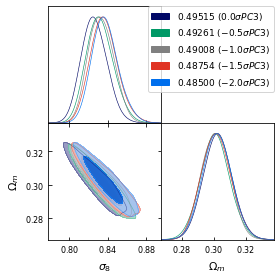

In [425]:
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, params=['sigma8','omegam'], filled=True)#, markers=truth_dict)

plot_cosmo_contours([emu_to_params(samples), 
                     emu_to_params(shifted_samples[0]),
                     emu_to_params(shifted_samples[1]),
                     emu_to_params(shifted_samples[2]),
                     emu_to_params(shifted_samples[3])],
                    ['{:.5f} $(0.0\sigma PC3)$'.format(truth_eb[pc]),
                     '{:.5f} $(-0.5\sigma PC3)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma PC3)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma PC3)$'.format(vals[2]),
                     '{:.5f} $(-2.0\sigma PC3)$'.format(vals[3])])

In [474]:
# now generate shifts in $\sigma_8$
var = re_chain.cov(['sigma8'])[0][0]
stdev = np.sqrt(var)
re_truth = truth_converted[0]
data_vectors = []
vals = []

for i in range(1,5):
    params = re_truth - i*stdev*np.array([1.,0.,0.,0.,0.]) # shift     
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    vals.append(params[0])
    print(params)
    print(-2*ln_lkl(np.array(cosmo_params)))
    data_vectors.append(dv)

[8.11740169e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]
54.61399957722833
[7.98462263e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]
201.41260465471242
[7.85184356e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]
448.1382075295011
[7.71906450e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]
791.25393938748


In [456]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|█████████████████████████████████████████████████| 5000/5000 [05:45<00:00, 14.45it/s]


(4, 42000, 5)
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


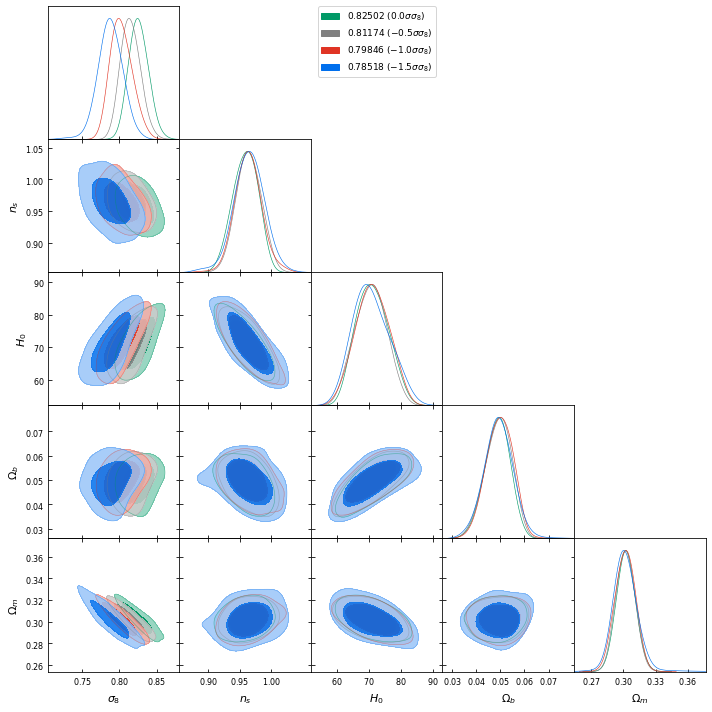

In [465]:
print(np.array(shifted_samples).shape)
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
    
    cosmo_truth = [3.0675, 0.97, 69., 0.0228528, 0.1199772]
    
    truth_dict = {}
    for name, truth in zip(names, cosmo_truth):
        truth_dict[name] = truth
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)
    g.export('s8-shift.pdf') 
plot_cosmo_contours([emu_to_params(samples), 
                     emu_to_params(shifted_samples[0]),
                     emu_to_params(shifted_samples[1]),
                     emu_to_params(shifted_samples[2])],
                     #emu_to_params(shifted_samples[3])],
                    ['{:.5f} $(0.0\sigma \sigma_8)$'.format(truth_converted[0][0]),
                     '{:.5f} $(-0.5\sigma \sigma_8)$'.format(vals[0]),
                     '{:.5f} $(-1.0\sigma \sigma_8)$'.format(vals[1]),
                     '{:.5f} $(-1.5\sigma \sigma_8)$'.format(vals[2])])#,
                     #'{:.5f} $(-2.0\sigma \sigma_8)$'.format(vals[3])])

                 

In [488]:
# now generate shifts in S8
samples = re_chain.samples
sigma8 = samples[:,0]
omegam = samples[:,4]

s8 = sigma8*np.sqrt(omegam/0.3)
s8_truth = re_truth[0]*np.sqrt(re_truth[4]/0.3)
print(re_truth)
stdev = np.std(s8)

#stdev = np.sqrt(var)
re_truth = truth_converted[0]
data_vectors = []
vals = []

for i in range(1,5):
    s8 = s8_truth-i*stdev
    sigma8 = s8*np.sqrt(0.3/re_truth[4])
    params = [sigma8,re_truth[1],re_truth[2],re_truth[3],re_truth[4]]
    cosmo_params = list(params_to_emu(np.array([params])))         # convert to emu params
    cosmo_params.append( [0., 0., 0., 0., 0.,
                      0.5, 0.,
                      0., 0., 0., 0., 0.,
                      1.24, 1.36, 1.47, 1.60, 1.76,
                      0., 0., 0., 0., 0.,
                      0., 0.,1.05,0.05,1.0])               # add systematics
    cosmo_params = [item for sublist in cosmo_params for item in sublist] # concatenate
    dv = get_data_vector_emu(np.array(cosmo_params))      #get datavector
    vals.append(params[0])
    print(-2*ln_lkl(np.array(cosmo_params)))
    data_vectors.append(dv)

[8.25018076e-01 9.70000000e-01 6.90000000e+01 4.80000000e-02
 3.01354628e-01]
85.34084793629243
37.95335575215228
9.51098389261783
-0.0


In [489]:
# now lets sample
shifted_samples = []

for dv in data_vectors:
    data_model.dv_obs = dv[0]
    emu_sampler = None
    with Pool(10) as pool:
        emu_sampler = emcee.EnsembleSampler(N_WALKERS, NDIM_SAMPLING, lnprob, pool=pool)
        emu_sampler.run_mcmc(pos0, N_MCMC, progress=True)
    _samples = emu_sampler.chain[:,N_BURN_IN::N_THIN].reshape((-1,NDIM_SAMPLING))
    _s = _samples[...,:5]
    shifted_samples.append(_s)

100%|█████████████████████████████████████████████████| 5000/5000 [05:48<00:00, 14.37it/s]


(4, 42000, 5)
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


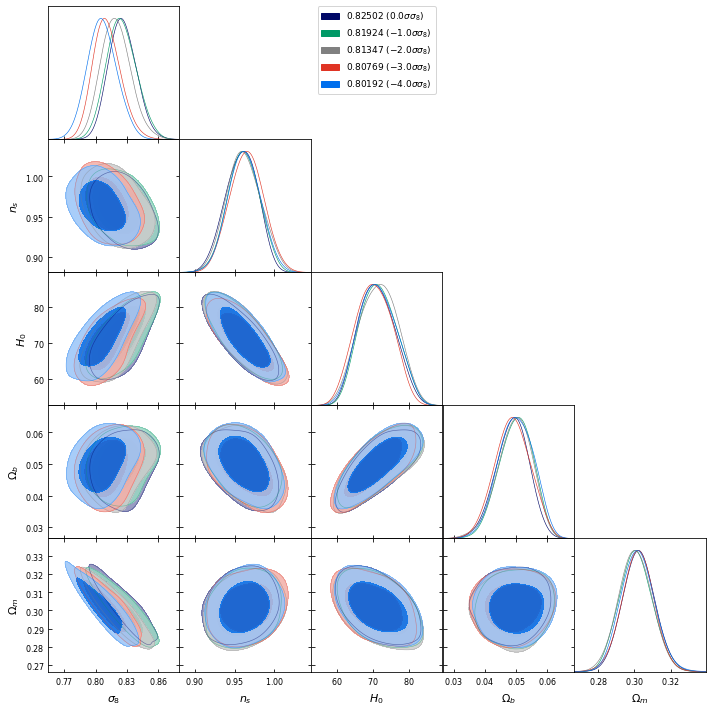

In [490]:
print(np.array(shifted_samples).shape)
def plot_cosmo_contours(sample_list, legend_labels):
    names = ['sigma8','ns','H0','Omegab','omegam']
    labels = ['\sigma_8','n_s','H_0','\Omega_b','\Omega_m']
        
    getdist_samples = []
    for samples, legend_label in zip(sample_list, legend_labels):
        cosmo_samples = samples[:,:5]
        getdist_samples.append(MCSamples(samples=cosmo_samples,names = names, labels=labels, label=legend_label))
    
    g = plots.get_subplot_plotter()
    g.triangle_plot(getdist_samples, filled=True)#, markers=truth_dict)
    g.export('s8-shift.pdf') 
    
samples = re_chain.samples
plot_cosmo_contours([samples, 
                     emu_to_params(shifted_samples[0]),
                     emu_to_params(shifted_samples[1]),
                     emu_to_params(shifted_samples[2]),
                     emu_to_params(shifted_samples[3])],
                    ['{:.5f} $(0.0\sigma \sigma_8)$'.format(truth_converted[0][0]),
                     '{:.5f} $(-1.0\sigma \sigma_8)$'.format(vals[0]),
                     '{:.5f} $(-2.0\sigma \sigma_8)$'.format(vals[1]),
                     '{:.5f} $(-3.0\sigma \sigma_8)$'.format(vals[2]),
                     '{:.5f} $(-4.0\sigma \sigma_8)$'.format(vals[3])])